<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Training_optic_Discs_in_Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection

Kaggle has a large competition of Diabetic Retinopathy detection which can be found here:
https://www.kaggle.com/c/diabetic-retinopathy-detection/

Their dataset consists in 35126 images labeled from 0 to 4 according to the degree of Retinopathy.
An analysis of the data is provided in this notebook.

In [2]:
!rm -rf sample_data
!nvidia-smi

Sat Feb 20 23:31:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install dependencies

In [3]:
from IPython.display import clear_output

!pip install torch==1.7.1+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install efficientnet_pytorch
clear_output(wait=False)

## Load data from local drive


In [4]:
!wget -O File.zip "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ETdcB8GscyBAkhUFvNMzpoUBLLgg7ej9Q3t4rK_bR8ngSA?download=1"
!unzip File.zip
!rm File.zip
clear_output(wait=False)
print("Data Downloaded")

Data Downloaded


In [1]:
!rm checkpoint*

In [1]:
import pandas as pd
import os

Bad =  pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Neovessels",File) for File in os.listdir("./OpticDiscs/Neovessels") if ".jpeg" in File]})
Good = pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Good images",File) for File in os.listdir("./OpticDiscs/Good images") if ".jpeg" in File]}).sample(len(Bad),random_state = 42)

data = pd.concat((Good,Bad),axis = 0)
data.head()
data['class'] = data['imageFilename'].apply(lambda x : 1 if "Good" in x else 0)
data = data.reset_index()
data = data[['imageFilename','class']]
data.head()

,imageFilename,class
0,./OpticDiscs/Good images/4270_left.jpeg,1
1,./OpticDiscs/Good images/26079_left.jpeg,1
2,./OpticDiscs/Good images/4998_right.jpeg,1
3,./OpticDiscs/Good images/21026_right.jpeg,1
4,./OpticDiscs/Good images/40631_left.jpeg,1


In [2]:
len(data)

374

#### Split data

In [3]:
from sklearn.model_selection import train_test_split

Train,Validation = train_test_split(data,test_size = 0.40,random_state = 65)
X_train = Train['imageFilename']
y_train = Train['class']
#Split data
X_validation, X_test, y_validation, y_test = train_test_split(Validation['imageFilename'], Validation['class'], test_size=0.50, random_state=65)


In [4]:
print("Datos de entrenamiento:")
print(y_train.value_counts())
print("Datos de validación:")
print(y_validation.value_counts())
print("Datos de test:")
print(y_test.value_counts())

Datos de entrenamiento:
0    119
1    105
Name: class, dtype: int64
Datos de validación:
1    44
0    31
Name: class, dtype: int64
Datos de test:
1    38
0    37
Name: class, dtype: int64


In [5]:
test_data = pd.DataFrame({'image':X_test,'class':y_test})
test_data['image'] = test_data['image'].apply(lambda x : x.split('/')[-1])
test_data.head()

,image,class
198,37829_left.jpeg,0
9,29712_left.jpeg,1
132,32085_right.jpeg,1
259,11896_left.jpeg,0
208,21096_left.jpeg,0


In [6]:
test_data.to_csv('test_data.csv',index=False)

## Definition of the model

In [7]:
import torchvision.models as models
import torch
network_name = 'densenet161'
model = models.densenet161(pretrained=True)

In [8]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [9]:
## Change efficientnet final layer
model.classifier = torch.nn.Linear(in_features=2208,out_features=2,bias = True)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

26476418

In [11]:
from torchvision.transforms import Resize,ToTensor,Compose,Normalize
from torchvision.transforms import RandomHorizontalFlip,RandomVerticalFlip,RandomRotation,ColorJitter,RandomResizedCrop,RandomPerspective,GaussianBlur
from PIL import Image

transforms = Compose([RandomHorizontalFlip(),RandomVerticalFlip(),
                      RandomRotation(180),ColorJitter(0.5,0.5,0.5),
                      RandomResizedCrop((224 ,224), scale=(0.7, 1.2)),
                      RandomPerspective(),
                      GaussianBlur((3,3))]) # Transformations for the training images

composed = Compose([Resize(224), # Resize to a fit size for efficientnet
                    ToTensor(),  # Convert into sensor
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize image

### Training parameters

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);
seed = 17
torch.manual_seed(seed)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [14]:
try:
    model = torch.load('./checkpoint_densenet161_87_0.93333.ph', map_location=device)
except:
    print("No Checkpoint loaded")

In [15]:
classes = {0:[0,0,0,0,1],
           1:[0,0,0,1,0],
           2:[0,0,1,0,0],
           3:[0,1,0,0,0],
           4:[1,0,0,0,0]}

In [16]:
from tqdm import tqdm
import random
random.seed(seed)

epochs = 100
batch_size = 1  # I will use batch size of 1 to keep the ratio of each image

TRAINING_acc = []
VALIDATION_acc = []
BEST_val_acc = 0.0

for epoch in range(epochs):
    
    indexes = [idx for idx in range(len(X_train))]
    pbar = tqdm( range(len(X_train)//batch_size),ncols = 100)
    running_loss = 0.0
    running_acc = 0.0
    t = 0

    for step in pbar:
        # Load data
        idx = random.sample(indexes,batch_size)
        X = X_train.iloc[idx]
        y = y_train.iloc[idx]

        # Remove indexes
        [indexes.remove(i) for i in idx]

        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = transforms(image)
            P = composed(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t += batch_size

        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == y_true).cpu().detach().numpy()
        acc = torch.sum(preds == y_true).cpu().detach().numpy()/batch_size;
        pbar.set_description("Epoch: {} Accuracy: {:0.5f} Loss: {:0.5f} ".format(epoch+1,running_acc/t,loss.item()))
    #Validation
    TRAINING_acc.append(running_acc/t)
    val_acc = 0.0
    val_loss = 0.0
    t = 0
    for point in range(len(X_validation)//batch_size):
        with torch.no_grad():

            X = X_validation.iloc[point*batch_size:(point+1)*batch_size]
            y = y_validation.iloc[point*batch_size:(point+1)*batch_size]


            # Load images
            try:
                images = [Image.open(File) for File in X]
            except:
                continue
            # Load y_true
            y_true = torch.LongTensor([c for c in y]).to(device)
            
            # Convert images to tensor
            x_batch = torch.FloatTensor().to(device)
            for image in images:
                P = composed(image).unsqueeze(0).to(device)
                x_batch = torch.cat((x_batch,P))

            
            outputs = model(x_batch)
            loss = criterion(outputs, y_true)
            val_loss += loss.item()
            t += batch_size
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == y_true).cpu().detach().numpy()
    VALIDATION_acc.append(val_acc/t)
    print("Validation -- Accuracy: {:0.5f} Loss: {:0.5f} \n".format(val_acc/t,loss.item()))
    if val_acc/t > BEST_val_acc:
        try:
            torch.save(model,"/content/checkpoint_{}_{}_{:0.5f}.ph".format(network_name,epoch+1,val_acc/t))
            BEST_val_acc = val_acc/t
        except:
            continue

Epoch: 1 Accuracy: 0.98214 Loss: 0.01787 : 100%|██████████████████| 224/224 [00:28<00:00,  7.90it/s]


Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 3 Accuracy: 1.00000 Loss: 0.08373 :   0%|                    | 1/224 [00:00<00:26,  8.29it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 4 Accuracy: 1.00000 Loss: 0.00780 :   0%|                    | 1/224 [00:00<00:26,  8.54it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 5 Accuracy: 1.00000 Loss: 0.01140 :   0%|                    | 1/224 [00:00<00:28,  7.91it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 6 Accuracy: 1.00000 Loss: 0.00759 :   0%|                    | 1/224 [00:00<00:24,  9.25it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 7 Accuracy: 1.00000 Loss: 0.00917 :   0%|                    | 1/224 [00:00<00:30,  7.22it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 8 Accuracy: 1.00000 Loss: 0.01681 :   0%|                    | 1/224 [00:00<00:25,  8.88it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 9 Accuracy: 1.00000 Loss: 0.01219 :   0%|                    | 1/224 [00:00<00:30,  7.20it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 10 Accuracy: 1.00000 Loss: 0.11547 :   0%|                   | 1/224 [00:00<00:33,  6.68it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 11 Accuracy: 1.00000 Loss: 0.01224 :   0%|                   | 1/224 [00:00<00:24,  9.18it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 12 Accuracy: 1.00000 Loss: 0.00721 :   0%|                   | 1/224 [00:00<00:29,  7.46it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 13 Accuracy: 1.00000 Loss: 0.04953 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 14 Accuracy: 1.00000 Loss: 0.15336 :   0%|                   | 1/224 [00:00<00:30,  7.22it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 15 Accuracy: 1.00000 Loss: 0.00964 :   0%|                   | 1/224 [00:00<00:26,  8.57it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 16 Accuracy: 1.00000 Loss: 0.45691 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 17 Accuracy: 1.00000 Loss: 0.03049 :   0%|                   | 1/224 [00:00<00:29,  7.61it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 18 Accuracy: 1.00000 Loss: 0.02641 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 19 Accuracy: 1.00000 Loss: 0.05446 :   0%|                   | 1/224 [00:00<00:25,  8.65it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 20 Accuracy: 1.00000 Loss: 0.06668 :   0%|                   | 1/224 [00:00<00:31,  7.06it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 21 Accuracy: 1.00000 Loss: 0.07767 :   0%|                   | 1/224 [00:00<00:33,  6.64it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 22 Accuracy: 1.00000 Loss: 0.00849 :   0%|                   | 1/224 [00:00<00:30,  7.34it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 24 Accuracy: 0.00000 Loss: 0.91742 :   0%|                   | 1/224 [00:00<00:27,  8.18it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 25 Accuracy: 1.00000 Loss: 0.00721 :   0%|                   | 1/224 [00:00<00:32,  6.87it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 26 Accuracy: 1.00000 Loss: 0.01789 :   0%|                   | 1/224 [00:00<00:23,  9.32it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 27 Accuracy: 0.00000 Loss: 1.67042 :   0%|                   | 1/224 [00:00<00:42,  5.23it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 28 Accuracy: 1.00000 Loss: 0.01784 :   0%|                   | 1/224 [00:00<00:34,  6.44it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 29 Accuracy: 1.00000 Loss: 0.00862 :   0%|                   | 1/224 [00:00<00:22,  9.71it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 30 Accuracy: 1.00000 Loss: 0.01900 :   0%|                   | 1/224 [00:00<00:25,  8.67it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 31 Accuracy: 1.00000 Loss: 0.02101 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 32 Accuracy: 1.00000 Loss: 0.00727 :   0%|                   | 1/224 [00:00<00:34,  6.49it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 33 Accuracy: 1.00000 Loss: 0.01253 :   1%|▏                  | 2/224 [00:00<00:21, 10.17it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 34 Accuracy: 1.00000 Loss: 0.02897 :   0%|                   | 1/224 [00:00<00:24,  9.07it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 35 Accuracy: 1.00000 Loss: 0.02326 :   1%|▏                  | 2/224 [00:00<00:21, 10.11it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 36 Accuracy: 1.00000 Loss: 0.00856 :   0%|                   | 1/224 [00:00<00:33,  6.61it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 37 Accuracy: 1.00000 Loss: 0.01432 :   0%|                   | 1/224 [00:00<00:28,  7.81it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 38 Accuracy: 1.00000 Loss: 0.04719 :   0%|                   | 1/224 [00:00<00:22, 10.00it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 39 Accuracy: 1.00000 Loss: 0.00885 :   0%|                   | 1/224 [00:00<00:27,  8.11it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 40 Accuracy: 1.00000 Loss: 0.01171 :   0%|                   | 1/224 [00:00<00:24,  9.01it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 41 Accuracy: 1.00000 Loss: 0.01442 :   0%|                   | 1/224 [00:00<00:28,  7.73it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 42 Accuracy: 1.00000 Loss: 0.01212 :   0%|                   | 1/224 [00:00<00:25,  8.77it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 43 Accuracy: 1.00000 Loss: 0.01492 :   0%|                   | 1/224 [00:00<00:25,  8.85it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 44 Accuracy: 1.00000 Loss: 0.00932 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 45 Accuracy: 1.00000 Loss: 0.01402 :   0%|                   | 1/224 [00:00<00:24,  9.16it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 46 Accuracy: 1.00000 Loss: 0.02527 :   0%|                   | 1/224 [00:00<00:26,  8.39it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 47 Accuracy: 1.00000 Loss: 0.00754 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 48 Accuracy: 1.00000 Loss: 0.02097 :   0%|                   | 1/224 [00:00<00:28,  7.77it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 49 Accuracy: 1.00000 Loss: 0.01918 :   1%|▏                  | 2/224 [00:00<00:21, 10.40it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 50 Accuracy: 1.00000 Loss: 0.03752 :   0%|                   | 1/224 [00:00<00:25,  8.66it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 51 Accuracy: 1.00000 Loss: 0.02566 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 52 Accuracy: 1.00000 Loss: 0.01697 :   0%|                   | 1/224 [00:00<00:25,  8.62it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 53 Accuracy: 1.00000 Loss: 0.00746 :   0%|                   | 1/224 [00:00<00:24,  9.05it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 54 Accuracy: 1.00000 Loss: 0.00777 :   0%|                   | 1/224 [00:00<00:31,  7.02it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 55 Accuracy: 1.00000 Loss: 0.01631 :   0%|                   | 1/224 [00:00<00:22,  9.99it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 56 Accuracy: 1.00000 Loss: 0.21384 :   0%|                   | 1/224 [00:00<00:29,  7.56it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 57 Accuracy: 1.00000 Loss: 0.00737 :   0%|                   | 1/224 [00:00<00:23,  9.56it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 58 Accuracy: 0.00000 Loss: 2.32244 :   0%|                   | 1/224 [00:00<00:32,  6.93it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 59 Accuracy: 1.00000 Loss: 0.05711 :   0%|                   | 1/224 [00:00<00:23,  9.40it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 60 Accuracy: 1.00000 Loss: 0.00694 :   0%|                   | 1/224 [00:00<00:30,  7.31it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 61 Accuracy: 1.00000 Loss: 0.32674 :   0%|                   | 1/224 [00:00<00:22,  9.91it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 62 Accuracy: 1.00000 Loss: 0.05137 :   0%|                   | 1/224 [00:00<00:31,  7.05it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 63 Accuracy: 1.00000 Loss: 0.00564 :   0%|                   | 1/224 [00:00<00:28,  7.71it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 64 Accuracy: 1.00000 Loss: 0.01161 :   0%|                   | 1/224 [00:00<00:30,  7.36it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 65 Accuracy: 1.00000 Loss: 0.02602 :   0%|                   | 1/224 [00:00<00:22,  9.78it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 66 Accuracy: 1.00000 Loss: 0.00789 :   0%|                   | 1/224 [00:00<00:33,  6.74it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 67 Accuracy: 1.00000 Loss: 0.08390 :   0%|                   | 1/224 [00:00<00:22,  9.84it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 68 Accuracy: 1.00000 Loss: 0.03533 :   0%|                   | 1/224 [00:00<00:35,  6.29it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 69 Accuracy: 1.00000 Loss: 0.01083 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 70 Accuracy: 1.00000 Loss: 0.01404 :   0%|                   | 1/224 [00:00<00:26,  8.32it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 71 Accuracy: 1.00000 Loss: 0.00893 :   0%|                   | 1/224 [00:00<00:31,  7.08it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 72 Accuracy: 1.00000 Loss: 0.04196 :   0%|                   | 1/224 [00:00<00:29,  7.58it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 73 Accuracy: 1.00000 Loss: 0.02216 :   0%|                   | 1/224 [00:00<00:32,  6.90it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 74 Accuracy: 1.00000 Loss: 0.02805 :   0%|                   | 1/224 [00:00<00:29,  7.68it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 75 Accuracy: 1.00000 Loss: 0.01531 :   0%|                   | 1/224 [00:00<00:27,  8.23it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 76 Accuracy: 1.00000 Loss: 0.03500 :   0%|                   | 1/224 [00:00<00:26,  8.56it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 78 Accuracy: 1.00000 Loss: 0.06643 :   0%|                   | 1/224 [00:00<00:25,  8.76it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 79 Accuracy: 1.00000 Loss: 0.00681 :   0%|                   | 1/224 [00:00<00:29,  7.60it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 80 Accuracy: 1.00000 Loss: 0.01679 :   0%|                   | 1/224 [00:00<00:23,  9.42it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 81 Accuracy: 1.00000 Loss: 0.00546 :   0%|                   | 1/224 [00:00<00:34,  6.50it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 82 Accuracy: 1.00000 Loss: 0.03316 :   0%|                   | 1/224 [00:00<00:22,  9.82it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 83 Accuracy: 1.00000 Loss: 0.03626 :   0%|                   | 1/224 [00:00<00:29,  7.47it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 84 Accuracy: 1.00000 Loss: 0.01093 :   1%|▏                  | 2/224 [00:00<00:21, 10.26it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 85 Accuracy: 1.00000 Loss: 0.00619 :   0%|                   | 1/224 [00:00<00:25,  8.80it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 86 Accuracy: 1.00000 Loss: 0.19240 :   0%|                   | 1/224 [00:00<00:23,  9.67it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 87 Accuracy: 1.00000 Loss: 0.23926 :   0%|                   | 1/224 [00:00<00:28,  7.79it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 88 Accuracy: 0.00000 Loss: 1.18151 :   0%|                   | 1/224 [00:00<00:40,  5.54it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 89 Accuracy: 1.00000 Loss: 0.00724 :   0%|                   | 1/224 [00:00<00:24,  9.14it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 90 Accuracy: 1.00000 Loss: 0.00925 :   0%|                   | 1/224 [00:00<00:29,  7.65it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 91 Accuracy: 1.00000 Loss: 0.00892 :   0%|                   | 1/224 [00:00<00:34,  6.54it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 92 Accuracy: 1.00000 Loss: 0.02023 :   0%|                   | 1/224 [00:00<00:27,  8.14it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 93 Accuracy: 1.00000 Loss: 0.00926 :   0%|                   | 1/224 [00:00<00:24,  9.20it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 94 Accuracy: 1.00000 Loss: 0.01572 :   0%|                   | 1/224 [00:00<00:23,  9.54it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 95 Accuracy: 1.00000 Loss: 0.00775 :   0%|                   | 1/224 [00:00<00:31,  7.10it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 96 Accuracy: 1.00000 Loss: 0.04062 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 97 Accuracy: 1.00000 Loss: 0.56866 :   0%|                   | 1/224 [00:00<00:28,  7.81it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 98 Accuracy: 1.00000 Loss: 0.01012 :   0%|                   | 1/224 [00:00<00:35,  6.30it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 99 Accuracy: 1.00000 Loss: 0.01340 :   0%|                   | 1/224 [00:00<00:30,  7.39it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 100 Accuracy: 1.00000 Loss: 0.01359 :   0%|                  | 1/224 [00:00<00:22,  9.73it/s]

Validation -- Accuracy: 0.93333 Loss: 0.01861 



Epoch: 100 Accuracy: 0.96875 Loss: 0.01117 : 100%|████████████████| 224/224 [00:30<00:00,  7.46it/s]


Validation -- Accuracy: 0.93333 Loss: 0.01861 



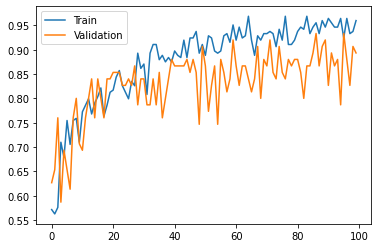

In [17]:
history = pd.DataFrame({"Train":TRAINING_acc,"Validation":VALIDATION_acc})
history.plot()

In [ ]:
!ls

checkpoint_densenet161_1_0.71681.ph   checkpoint_densenet161_60_0.96460.ph
checkpoint_densenet161_12_0.91150.ph  checkpoint_densenet161_6_0.88496.ph
checkpoint_densenet161_18_0.93805.ph  checkpoint_densenet161_9_0.89381.ph
checkpoint_densenet161_2_0.82301.ph   OpticDiscs
checkpoint_densenet161_3_0.83186.ph   test_data.csv
checkpoint_densenet161_5_0.84956.ph


In [22]:
torch.save(model,"checkpointDENSENET.ph")

In [ ]:
for c in y:
  print(c)

1


## Evaluation

In [24]:
model = torch.load('checkpoint_densenet161_15_0.89333.ph')

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [18]:
predicted = []
true_values = []
for point in range(len(X_test)//batch_size):
    with torch.no_grad():

        X = X_test.iloc[point*batch_size:(point+1)*batch_size]
        y = y_test.iloc[point*batch_size:(point+1)*batch_size]

        true_values.append(y.values)
        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = composed(image).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        
        _, preds = torch.max(outputs, 1)
        predicted.append(preds)

In [19]:
true_values = np.array(true_values).reshape(-1)
dummy = torch.FloatTensor().to(device)
for tensor in predicted:
    dummy = torch.cat((dummy,tensor))
predicted = dummy.view(-1).cpu().numpy()

In [20]:
confusion_matrix(true_values, predicted)

array([[33,  4],
       [ 5, 33]])

In [23]:
(66)/(75)

0.88